In [10]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import csv
data = []
with open("cleaned/OR.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        data.append(int(i[5]))

train  = data[:-300]
test = data[-300:]

li_x = []
li_y = []
seq = 2

# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[:-300]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

t_x = []
t_y = []
# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[-300:]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据*
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

# print(li_x)
# print(li_y)

# 分训练和测试集
train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)

print(train_x.shape)

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

torch.Size([408, 2, 1])


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [14]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fun = nn.MSELoss()

In [15]:
model.train()
for epoch in range(1200):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))

epoch:20, loss:0.1335323601961136, test_loss: 0.5457881093025208
epoch:40, loss:0.07744254171848297, test_loss: 0.3632943332195282
epoch:60, loss:0.04869963973760605, test_loss: 0.345846027135849
epoch:80, loss:0.04658201336860657, test_loss: 0.3286527991294861
epoch:100, loss:0.04518294706940651, test_loss: 0.32691749930381775
epoch:120, loss:0.043810080736875534, test_loss: 0.32851019501686096
epoch:140, loss:0.04261746630072594, test_loss: 0.33051612973213196
epoch:160, loss:0.04168777912855148, test_loss: 0.33423975110054016
epoch:180, loss:0.0410553477704525, test_loss: 0.3384191393852234
epoch:200, loss:0.040659479796886444, test_loss: 0.341928631067276
epoch:220, loss:0.04039086401462555, test_loss: 0.3439502716064453
epoch:240, loss:0.04016859456896782, test_loss: 0.34459513425827026
epoch:260, loss:0.03996450826525688, test_loss: 0.3445695638656616
epoch:280, loss:0.039774779230356216, test_loss: 0.3445318639278412
epoch:300, loss:0.0395982451736927, test_loss: 0.3447800576686

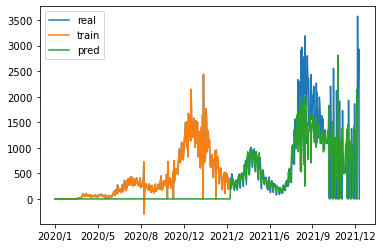

In [16]:
model.eval()
# result = li_x[0][:seq-1] + list((model(train_x).data.reshape(-1))*1000) + list((model(test_x).data.reshape(-1))*1000)
result = [0] + list((model(train_x).data.reshape(-1))*00) + list((model(test_x).data.reshape(-1))*1000)
#展示结果
plt.plot(data,label="real")
# 原来的走势

plt.plot(train,label="train")

plt.plot(result,label="pred")
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '20211/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')
plt.savefig('plot/OR_Epoch1200.jpg')

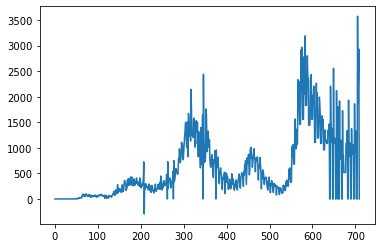

In [17]:
plt.plot(data)

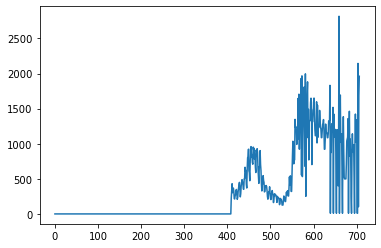

In [18]:
plt.plot(result)